### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [5]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [6]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [7]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [8]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

In [9]:
fine_tune_data = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 512)

In [10]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [11]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 512)

In [12]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [13]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 512)

In [14]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

In [15]:
N_COMPS = 256
pcas = [PCA(N_COMPS) for _ in range(5)]

In [16]:
for i in range(5):
    pcas[i].fit(fine_tune_data_train[:,i,:])

In [17]:
fine_tune_data_train_red = np.zeros((fine_tune_data_train.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_train_red[:,i,:] = pcas[i].transform(fine_tune_data_train[:,i,:])

In [18]:
fine_tune_data_train_red.shape

(15200, 5, 256)

In [19]:
fine_tune_data_test_red = np.zeros((fine_tune_data_test.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_test_red[:,i,:] = pcas[i].transform(fine_tune_data_test[:,i,:])

In [20]:
fine_tune_data_test_red.shape

(800, 5, 256)

## Fine-Tuning Models

The fine-tuning part of our model.

In [23]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='VGG16-FineTune')
    return model1

In [24]:
model1 = ftmodel()
model1.summary()

Model: "VGG16-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 256)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 1280)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               655872    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                    

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [25]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [26]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/VGG16-4P-PCA/auto-VGG16-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [27]:
history = model1.fit(fine_tune_data_train_red, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test_red, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/VGG16-4P-PCA/vgg16-4p-model-weights")
model1.load_weights('./Models/VGG16-4P-PCA/vgg16-4p-model-weights')

Epoch 1/1000


2022-10-08 20:27:18.707210: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-08 20:27:19.031419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 22ms/step - loss: 3.2751 - accuracy: 0.1465 - val_loss: 2.2599 - val_accuracy: 0.3837
Epoch 2/1000
 8/19 [===========>..................] - ETA: 0s - loss: 2.5440 - accuracy: 0.3105

2022-10-08 20:27:19.545172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 12ms/step - loss: 2.3870 - accuracy: 0.3539 - val_loss: 1.8141 - val_accuracy: 0.5250
Epoch 3/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.9449 - accuracy: 0.4658 - val_loss: 1.5873 - val_accuracy: 0.5875
Epoch 4/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.6927 - accuracy: 0.5370 - val_loss: 1.4516 - val_accuracy: 0.6250
Epoch 5/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.5316 - accuracy: 0.5791 - val_loss: 1.3572 - val_accuracy: 0.6413
Epoch 6/1000
19/19 [==============================] - 0s 14ms/step - loss: 1.3979 - accuracy: 0.6158 - val_loss: 1.2891 - val_accuracy: 0.6500
Epoch 7/1000
19/19 [==============================] - 0s 11ms/step - loss: 1.3123 - accuracy: 0.6403 - val_loss: 1.2408 - val_accuracy: 0.6600
Epoch 8/1000
19/19 [==============================] - 0s 11ms/step - loss: 1.2395 - accuracy: 0.6589 - val_loss: 1.2016 - val_accuracy: 0.6737
Epoch 9/1000

19/19 [==============================] - 0s 9ms/step - loss: 0.4384 - accuracy: 0.8815 - val_loss: 1.0633 - val_accuracy: 0.7362
Epoch 60/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.4259 - accuracy: 0.8880 - val_loss: 1.0636 - val_accuracy: 0.7387
Epoch 61/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.4173 - accuracy: 0.8905 - val_loss: 1.0612 - val_accuracy: 0.7387
Epoch 62/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.4180 - accuracy: 0.8908 - val_loss: 1.0602 - val_accuracy: 0.7425
Epoch 63/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.4104 - accuracy: 0.8949 - val_loss: 1.0656 - val_accuracy: 0.7400
Epoch 64/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.4010 - accuracy: 0.8947 - val_loss: 1.0661 - val_accuracy: 0.7450
Epoch 65/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.3984 - accuracy: 0.8975 - val_loss: 1.0692 - val_accuracy: 0.7462
Epoch 66

Epoch 116/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1970 - accuracy: 0.9620 - val_loss: 1.1510 - val_accuracy: 0.7387
Epoch 117/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1947 - accuracy: 0.9618 - val_loss: 1.1536 - val_accuracy: 0.7450
Epoch 118/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1938 - accuracy: 0.9618 - val_loss: 1.1567 - val_accuracy: 0.7450
Epoch 119/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1907 - accuracy: 0.9642 - val_loss: 1.1575 - val_accuracy: 0.7425
Epoch 120/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1896 - accuracy: 0.9640 - val_loss: 1.1577 - val_accuracy: 0.7425
Epoch 121/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1850 - accuracy: 0.9636 - val_loss: 1.1533 - val_accuracy: 0.7437
Epoch 122/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1891 - accuracy: 0.9611 - val_loss: 1.1470 - val_acc

19/19 [==============================] - 0s 11ms/step - loss: 0.1202 - accuracy: 0.9836 - val_loss: 1.2175 - val_accuracy: 0.7500
Epoch 173/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1205 - accuracy: 0.9828 - val_loss: 1.2250 - val_accuracy: 0.7537
Epoch 174/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1198 - accuracy: 0.9846 - val_loss: 1.2230 - val_accuracy: 0.7525
Epoch 175/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1212 - accuracy: 0.9821 - val_loss: 1.2272 - val_accuracy: 0.7500
Epoch 176/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1200 - accuracy: 0.9822 - val_loss: 1.2308 - val_accuracy: 0.7537
Epoch 177/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1237 - accuracy: 0.9811 - val_loss: 1.2353 - val_accuracy: 0.7525
Epoch 178/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1168 - accuracy: 0.9828 - val_loss: 1.2338 - val_accuracy: 0.7562
Epo

Epoch 229/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0953 - accuracy: 0.9886 - val_loss: 1.2295 - val_accuracy: 0.7450
Epoch 230/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0936 - accuracy: 0.9891 - val_loss: 1.2267 - val_accuracy: 0.7475
Epoch 231/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0949 - accuracy: 0.9891 - val_loss: 1.2315 - val_accuracy: 0.7537
Epoch 232/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0954 - accuracy: 0.9895 - val_loss: 1.2295 - val_accuracy: 0.7487
Epoch 233/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0988 - accuracy: 0.9876 - val_loss: 1.2324 - val_accuracy: 0.7500
Epoch 234/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0945 - accuracy: 0.9899 - val_loss: 1.2379 - val_accuracy: 0.7537
Epoch 235/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0970 - accuracy: 0.9894 - val_loss: 1.2448 - val_accura

Epoch 286/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0823 - accuracy: 0.9916 - val_loss: 1.3084 - val_accuracy: 0.7550
Epoch 287/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0826 - accuracy: 0.9916 - val_loss: 1.3026 - val_accuracy: 0.7525
Epoch 288/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0823 - accuracy: 0.9916 - val_loss: 1.2969 - val_accuracy: 0.7562
Epoch 289/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0815 - accuracy: 0.9921 - val_loss: 1.2970 - val_accuracy: 0.7600
Epoch 290/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0828 - accuracy: 0.9918 - val_loss: 1.2852 - val_accuracy: 0.7612
Epoch 291/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0815 - accuracy: 0.9926 - val_loss: 1.2921 - val_accuracy: 0.7587
Epoch 292/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.9901 - val_loss: 1.2910 - val_accuracy

Epoch 343/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 0.9926 - val_loss: 1.3442 - val_accuracy: 0.7587
Epoch 344/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0786 - accuracy: 0.9924 - val_loss: 1.3578 - val_accuracy: 0.7550
Epoch 345/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0780 - accuracy: 0.9922 - val_loss: 1.3568 - val_accuracy: 0.7587
Epoch 346/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0768 - accuracy: 0.9932 - val_loss: 1.3521 - val_accuracy: 0.7575
Epoch 347/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0756 - accuracy: 0.9927 - val_loss: 1.3437 - val_accuracy: 0.7525
Epoch 348/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0785 - accuracy: 0.9921 - val_loss: 1.3448 - val_accuracy: 0.7550
Epoch 349/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0755 - accuracy: 0.9932 - val_loss: 1.3413 - val_accura

Epoch 400/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0718 - accuracy: 0.9941 - val_loss: 1.3968 - val_accuracy: 0.7500
Epoch 401/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0725 - accuracy: 0.9940 - val_loss: 1.4025 - val_accuracy: 0.7562
Epoch 402/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0700 - accuracy: 0.9946 - val_loss: 1.4072 - val_accuracy: 0.7550
Epoch 403/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0711 - accuracy: 0.9939 - val_loss: 1.4024 - val_accuracy: 0.7537
Epoch 404/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0706 - accuracy: 0.9939 - val_loss: 1.3975 - val_accuracy: 0.7550
Epoch 405/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0710 - accuracy: 0.9943 - val_loss: 1.3986 - val_accuracy: 0.7525
Epoch 406/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0744 - accuracy: 0.9933 - val_loss: 1.3949 - val_accurac

Epoch 457/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0718 - accuracy: 0.9942 - val_loss: 1.4155 - val_accuracy: 0.7587
Epoch 458/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0688 - accuracy: 0.9948 - val_loss: 1.4147 - val_accuracy: 0.7612
Epoch 459/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0708 - accuracy: 0.9938 - val_loss: 1.4086 - val_accuracy: 0.7662
Epoch 460/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0677 - accuracy: 0.9950 - val_loss: 1.4188 - val_accuracy: 0.7625
Epoch 461/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0698 - accuracy: 0.9935 - val_loss: 1.4219 - val_accuracy: 0.7587
Epoch 462/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0670 - accuracy: 0.9953 - val_loss: 1.4175 - val_accuracy: 0.7562
Epoch 463/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0655 - accuracy: 0.9959 - val_loss: 1.4224 - val_accurac

Epoch 514/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0679 - accuracy: 0.9938 - val_loss: 1.4311 - val_accuracy: 0.7537
Epoch 515/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0640 - accuracy: 0.9955 - val_loss: 1.4418 - val_accuracy: 0.7550
Epoch 516/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0653 - accuracy: 0.9951 - val_loss: 1.4403 - val_accuracy: 0.7562
Epoch 517/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0648 - accuracy: 0.9950 - val_loss: 1.4330 - val_accuracy: 0.7562
Epoch 518/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0672 - accuracy: 0.9945 - val_loss: 1.4225 - val_accuracy: 0.7550
Epoch 519/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0632 - accuracy: 0.9960 - val_loss: 1.4217 - val_accuracy: 0.7537
Epoch 520/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0705 - accuracy: 0.9942 - val_loss: 1.4273 - val_accura

Epoch 571/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0659 - accuracy: 0.9945 - val_loss: 1.4055 - val_accuracy: 0.7650
Epoch 572/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0682 - accuracy: 0.9944 - val_loss: 1.4172 - val_accuracy: 0.7625
Epoch 573/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0638 - accuracy: 0.9954 - val_loss: 1.4214 - val_accuracy: 0.7637
Epoch 574/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0641 - accuracy: 0.9951 - val_loss: 1.4244 - val_accuracy: 0.7612
Epoch 575/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0630 - accuracy: 0.9952 - val_loss: 1.4296 - val_accuracy: 0.7625
Epoch 576/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0617 - accuracy: 0.9959 - val_loss: 1.4319 - val_accuracy: 0.7625
Epoch 577/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0657 - accuracy: 0.9943 - val_loss: 1.4329 - val_accura

Epoch 628/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0648 - accuracy: 0.9947 - val_loss: 1.4372 - val_accuracy: 0.7650
Epoch 629/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0635 - accuracy: 0.9955 - val_loss: 1.4234 - val_accuracy: 0.7662
Epoch 630/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0655 - accuracy: 0.9945 - val_loss: 1.4103 - val_accuracy: 0.7700
Epoch 631/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0659 - accuracy: 0.9943 - val_loss: 1.4169 - val_accuracy: 0.7662
Epoch 632/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0651 - accuracy: 0.9952 - val_loss: 1.4133 - val_accuracy: 0.7675
Epoch 633/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0629 - accuracy: 0.9945 - val_loss: 1.4055 - val_accuracy: 0.7713
Epoch 634/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0623 - accuracy: 0.9948 - val_loss: 1.4052 - val_accuracy

Epoch 685/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.9952 - val_loss: 1.4460 - val_accuracy: 0.7675
Epoch 686/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0598 - accuracy: 0.9962 - val_loss: 1.4422 - val_accuracy: 0.7688
Epoch 687/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0589 - accuracy: 0.9967 - val_loss: 1.4493 - val_accuracy: 0.7688
Epoch 688/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.9953 - val_loss: 1.4364 - val_accuracy: 0.7675
Epoch 689/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0610 - accuracy: 0.9959 - val_loss: 1.4336 - val_accuracy: 0.7662
Epoch 690/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0606 - accuracy: 0.9961 - val_loss: 1.4393 - val_accuracy: 0.7675
Epoch 691/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0608 - accuracy: 0.9952 - val_loss: 1.4310 - val_accuracy

Epoch 742/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0603 - accuracy: 0.9955 - val_loss: 1.4460 - val_accuracy: 0.7700
Epoch 743/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0605 - accuracy: 0.9959 - val_loss: 1.4569 - val_accuracy: 0.7725
Epoch 744/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0610 - accuracy: 0.9955 - val_loss: 1.4459 - val_accuracy: 0.7750
Epoch 745/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0610 - accuracy: 0.9958 - val_loss: 1.4436 - val_accuracy: 0.7750
Epoch 746/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0590 - accuracy: 0.9962 - val_loss: 1.4330 - val_accuracy: 0.7738
Epoch 747/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0650 - accuracy: 0.9945 - val_loss: 1.4276 - val_accuracy: 0.7688
Epoch 748/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0581 - accuracy: 0.9965 - val_loss: 1.4292 - val_accuracy

Epoch 799/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0588 - accuracy: 0.9963 - val_loss: 1.4638 - val_accuracy: 0.7650
Epoch 800/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0592 - accuracy: 0.9959 - val_loss: 1.4626 - val_accuracy: 0.7688
Epoch 801/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0602 - accuracy: 0.9954 - val_loss: 1.4662 - val_accuracy: 0.7725
Epoch 802/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0597 - accuracy: 0.9963 - val_loss: 1.4646 - val_accuracy: 0.7750
Epoch 803/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0600 - accuracy: 0.9956 - val_loss: 1.4529 - val_accuracy: 0.7713
Epoch 804/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0607 - accuracy: 0.9950 - val_loss: 1.4391 - val_accuracy: 0.7750
Epoch 805/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0625 - accuracy: 0.9956 - val_loss: 1.4326 - val_accu

Epoch 856/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0596 - accuracy: 0.9957 - val_loss: 1.4455 - val_accuracy: 0.7675
Epoch 857/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0587 - accuracy: 0.9961 - val_loss: 1.4502 - val_accuracy: 0.7650
Epoch 858/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0575 - accuracy: 0.9966 - val_loss: 1.4508 - val_accuracy: 0.7650
Epoch 859/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0588 - accuracy: 0.9957 - val_loss: 1.4510 - val_accuracy: 0.7637
Epoch 860/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0572 - accuracy: 0.9964 - val_loss: 1.4678 - val_accuracy: 0.7675
Epoch 861/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0592 - accuracy: 0.9962 - val_loss: 1.4651 - val_accuracy: 0.7738
Epoch 862/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0572 - accuracy: 0.9957 - val_loss: 1.4662 - val_accuracy

Epoch 913/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0598 - accuracy: 0.9947 - val_loss: 1.4820 - val_accuracy: 0.7575
Epoch 914/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0585 - accuracy: 0.9959 - val_loss: 1.4855 - val_accuracy: 0.7600
Epoch 915/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0585 - accuracy: 0.9961 - val_loss: 1.4832 - val_accuracy: 0.7662
Epoch 916/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0575 - accuracy: 0.9958 - val_loss: 1.4835 - val_accuracy: 0.7688
Epoch 917/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0596 - accuracy: 0.9947 - val_loss: 1.4773 - val_accuracy: 0.7650
Epoch 918/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0570 - accuracy: 0.9960 - val_loss: 1.4765 - val_accuracy: 0.7600
Epoch 919/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0572 - accuracy: 0.9964 - val_loss: 1.4761 - val_accuracy:

Epoch 970/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0554 - accuracy: 0.9964 - val_loss: 1.4656 - val_accuracy: 0.7612
Epoch 971/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0579 - accuracy: 0.9959 - val_loss: 1.4665 - val_accuracy: 0.7675
Epoch 972/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0581 - accuracy: 0.9960 - val_loss: 1.4749 - val_accuracy: 0.7688
Epoch 973/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0561 - accuracy: 0.9966 - val_loss: 1.4784 - val_accuracy: 0.7675
Epoch 974/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0565 - accuracy: 0.9961 - val_loss: 1.4647 - val_accuracy: 0.7675
Epoch 975/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0579 - accuracy: 0.9951 - val_loss: 1.4627 - val_accuracy: 0.7713
Epoch 976/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0586 - accuracy: 0.9957 - val_loss: 1.4725 - val_accuracy:

In [28]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

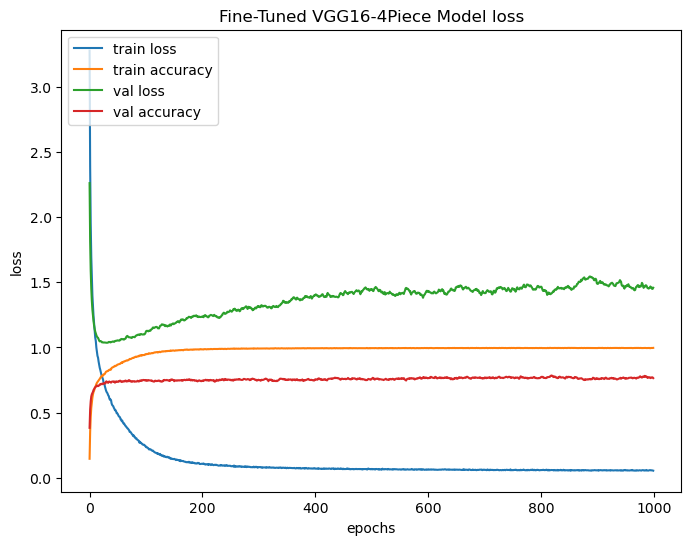

In [29]:
plot_train_loss(history, 'Fine-Tuned VGG16-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [30]:
train_preds = model1.predict(fine_tune_data_train_red)

 85/475 [====>.........................] - ETA: 0s

2022-10-08 20:30:25.907675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 2ms/step


In [31]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [32]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [33]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [34]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [35]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [36]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 2ms/step


In [37]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [38]:
test_pred_labels

array([11,  8,  6,  1,  1,  9, 13, 12, 14,  1,  6, 15,  0, 14, 13,  4,  0,
        6,  6, 12, 10, 14,  3, 12,  6,  0,  3, 14,  3,  3, 11,  1,  6,  2,
        1,  8,  4, 10,  1,  9,  6, 12, 14,  2,  5, 14, 13,  0, 13,  4,  0,
       10,  5,  0, 11, 14, 15,  6,  9,  2, 15, 13, 11, 11,  6, 11,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12,  0, 11, 14, 12, 12,  9,
        8,  5, 13, 13, 15, 10, 11,  4, 10,  7,  7, 11, 11, 13, 10, 13, 10,
       12,  9,  1, 14,  8,  2,  5,  5,  7,  7,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1, 15, 11,  1, 15, 12, 12,  0,  7,  3,  1,  6,  5,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4,  1, 13,  8,  2,  5,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  9,  3,  0, 10, 13, 13, 10, 11, 11,  5,  1,  9,  1,
        9, 15, 13, 10, 12,  1,  4,  8,  7,  6, 13,  9,  4, 12,  8,  0,  9,
       13, 15, 12,  7,  7

In [39]:
np.sum(test_pred_labels == test_labels['label'])

612

In [40]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
14,203,./Data/train/train/203.tif,1
15,239,./Data/train/train/239.tif,11
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [41]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.750000,0.777778,0.763636,54
1,0.565217,0.590909,0.577778,44
2,0.909091,0.930233,0.919540,43
3,0.952381,0.869565,0.909091,46
4,0.825000,0.916667,0.868421,36
5,0.694444,0.500000,0.581395,50
6,0.833333,0.869565,0.851064,46
7,0.763636,0.807692,0.785047,52
8,0.894737,0.944444,0.918919,54
9,0.800000,0.680851,0.735632,47


In [42]:
np.mean(fscore)

0.7635978649331854

#### On Validation Data

Generating Predictions for the Validation Set

In [43]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [44]:
fine_tune_data_validation = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')

In [45]:
fine_tune_data_validation.shape

(900, 5, 512)

In [46]:
fine_tune_data_validation_red = np.zeros((fine_tune_data_validation.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_validation_red[:,i,:] = pcas[i].transform(fine_tune_data_validation[:,i,:])

In [47]:
valid_preds = model1.predict(fine_tune_data_validation_red)

29/29 [==============================] - 0s 2ms/step


2022-10-08 20:30:27.060623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [48]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [49]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,6
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,1
896,18697,12
897,18698,8
898,18699,4


In [50]:
submission_data.to_csv('./Submissions/submission-VGG16-4p-PCA.csv', index=False)